<a href="https://colab.research.google.com/github/mphipps2/covid-19_open_data_projects/blob/main/covid_geoplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
project_id = "mphipps2"

from google.colab import auth

import humanize
auth.authenticate_user()
print('Authenticated')

from google.cloud import bigquery
import pandas as pd

my_project = "bigquery-public-data"
my_dataset = "covid19_open_data"
my_table = "covid19_open_data"
# Using BigQuery w/ Cloud API: https://colab.research.google.com/notebooks/snippets/bigquery.ipynb#scrollTo=HeZN5bOEl2iI
client = bigquery.Client(project=project_id)



Authenticated


In [ ]:
dataset_ref = client.dataset(my_dataset,project=my_project)

dataset = client.get_dataset(dataset_ref)
tables = list(client.list_tables(dataset))
for table in tables:
        print(table.table_id)

compatibility_view
covid19_open_data


In [ ]:
table_ref = dataset_ref.table(my_table)
table = client.get_table(table_ref)
print(table.schema)

covid_df = client.list_rows(table, max_results=5).to_dataframe()
covid_df.head()

[SchemaField('location_key', 'STRING', 'NULLABLE', None, ()), SchemaField('date', 'DATE', 'NULLABLE', None, ()), SchemaField('place_id', 'STRING', 'NULLABLE', None, ()), SchemaField('wikidata_id', 'STRING', 'NULLABLE', None, ()), SchemaField('datacommons_id', 'STRING', 'NULLABLE', None, ()), SchemaField('country_code', 'STRING', 'NULLABLE', None, ()), SchemaField('country_name', 'STRING', 'NULLABLE', None, ()), SchemaField('iso_3166_1_alpha_2', 'STRING', 'NULLABLE', None, ()), SchemaField('iso_3166_1_alpha_3', 'STRING', 'NULLABLE', None, ()), SchemaField('aggregation_level', 'INTEGER', 'NULLABLE', None, ()), SchemaField('new_confirmed', 'INTEGER', 'NULLABLE', None, ()), SchemaField('new_deceased', 'INTEGER', 'NULLABLE', None, ()), SchemaField('cumulative_confirmed', 'INTEGER', 'NULLABLE', None, ()), SchemaField('cumulative_deceased', 'INTEGER', 'NULLABLE', None, ()), SchemaField('cumulative_tested', 'INTEGER', 'NULLABLE', None, ()), SchemaField('new_persons_vaccinated', 'INTEGER', 'NUL

,location_key,date,place_id,wikidata_id,datacommons_id,country_code,country_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,cumulative_tested,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,population,population_male,population_female,population_rural,population_urban,population_density,human_development_index,population_age_00_09,population_age_10_19,population_age_20_29,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_and_older,gdp_usd,gdp_per_capita_usd,openstreetmap_id,...,new_recovered_age_1,new_recovered_age_2,new_recovered_age_3,new_recovered_age_4,new_recovered_age_5,new_recovered_age_6,new_recovered_age_7,new_recovered_age_8,new_recovered_age_9,cumulative_recovered_age_0,cumulative_recovered_age_1,cumulative_recovered_age_2,cumulative_recovered_age_3,cumulative_recovered_age_4,cumulative_recovered_age_5,cumulative_recovered_age_6,cumulative_recovered_age_7,cumulative_recovered_age_8,cumulative_recovered_age_9,new_recovered_male,new_recovered_female,cumulative_recovered_male,cumulative_recovered_female,locality_code,locality_name,new_ventilator_patients,cumulative_ventilator_patients,new_persons_fully_vaccinated_pfizer,cumulative_persons_fully_vaccinated_pfizer,new_vaccine_doses_administered_pfizer,cumulative_vaccine_doses_administered_pfizer,new_persons_fully_vaccinated_moderna,cumulative_persons_fully_vaccinated_moderna,new_vaccine_doses_administered_moderna,cumulative_vaccine_doses_administered_moderna,new_persons_fully_vaccinated_janssen,cumulative_persons_fully_vaccinated_janssen,new_vaccine_doses_administered_janssen,cumulative_vaccine_doses_administered_janssen,location_geometry
0,AR,2020-06-08,ChIJZ8b99fXKvJURqA_wKpl3Lz0,Q414,country/ARG,AR,Argentina,AR,ARG,0,1037,46,24828,942,204266,NaN,NaN,NaN,NaN,NaN,NaN,44938712,19523766,20593330,3599141,41339571,16.515,0.825,6718871,7045513,6430658,5777148,4507125,3911943,2914251,1817557,994030,449663446954,10006,286393,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT(-64 -34)
1,AR,2020-12-12,ChIJZ8b99fXKvJURqA_wKpl3Lz0,Q414,country/ARG,AR,Argentina,AR,ARG,0,4583,140,1517275,43989,3804660,NaN,NaN,NaN,NaN,NaN,NaN,44938712,19523766,20593330,3599141,41339571,16.515,0.825,6718871,7045513,6430658,5777148,4507125,3911943,2914251,1817557,994030,449663446954,10006,286393,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT(-64 -34)
2,AR,2021-10-01,ChIJZ8b99fXKvJURqA_wKpl3Lz0,Q414,country/ARG,AR,Argentina,AR,ARG,0,1236,18,5265606,116091,18037474,6.0,3885.0,32.0,2913.0,38.0,6798.0,44938712,19523766,20593330,3599141,41339571,16.515,0.825,6718871,7045513,6430658,5777148,4507125,3911943,2914251,1817557,994030,449663446954,10006,286393,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT(-64 -34)
3,AR,2021-02-11,ChIJZ8b99fXKvJURqA_wKpl3Lz0,Q414,country/ARG,AR,Argentina,AR,ARG,0,7133,125,2036269,53298,5941575,1.0,55.0,1.0,30.0,2.0,85.0,44938712,19523766,20593330,3599141,41339571,16.515,0.825,6718871,7045513,6430658,5777148,4507125,3911943,2914251,1817557,994030,449663446954,10006,286393,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT(-64 -34)
4,AR,2021-05-20,ChIJZ8b99fXKvJURqA_wKpl3Lz0,Q414,cou

In [ ]:
from time import time
def show_amount_of_data_scanned(query):
    # dry_run lets us see how much data the query uses without running it
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))

In [ ]:

sample_count = 100

ONE_GB = 1000*1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_GB)

my_query = '''
  SELECT
    location_key, EXTRACT(DAY from date) AS Day,  EXTRACT(MONTH from date) AS Month,  EXTRACT(YEAR from date) AS Year, new_confirmed/(population/1000) AS cases_per_1k, ST_X(location_geometry) AS long, ST_Y(location_geometry) AS lat
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE 
    EXTRACT(YEAR from date) = 2022 and EXTRACT(DAY from date) > 1 and aggregation_level = 2 and country_code = "US"
  GROUP BY location_key, Day, Month, Year, cases_per_1k, long, lat
  ORDER BY Day
'''

show_amount_of_data_scanned(my_query)
show_time_to_run(my_query)
covid_df = client.query(my_query).result().to_dataframe()

for col in covid_df.columns:
        print(col)

print("number of results: " , len(covid_df))

covid_df.head()

Data processed: 1.698 GB
Time to run: 1.956 seconds
location_key
Day
Month
Year
cases_per_1k
long
lat
number of results:  35475


,location_key,Day,Month,Year,cases_per_1k,long,lat
0,US_GA_13049,2,1,2022,0.000000,-82.140000,30.780000
1,US_GA_13069,2,1,2022,0.000000,-82.850000,31.550000
2,US_GA_13317,2,1,2022,0.000000,-82.740000,33.790000
3,US_IN_18007,2,1,2022,0.463446,-87.310000,40.610000
4,US_AL_01097,2,1,2022,3.994735,-88.213889,30.786389


In [ ]:
!pip install geopandas
!pip install shapely

import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab_data/'  #change dir to your project folder

state_df = gpd.read_file(root_path+'cb_2020_us_county_500k.shp')
type(state_df)
state_df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,21,141,00516917,0500000US21141,21141,Logan,Logan County,KY,Kentucky,06,1430224002,12479211,"POLYGON ((-87.06037 36.68085, -87.06002 36.708..."
1,36,081,00974139,0500000US36081,36081,Queens,Queens County,NY,New York,06,281594050,188444349,"POLYGON ((-73.96262 40.73903, -73.96243 40.739..."
2,34,017,00882278,0500000US34017,34017,Hudson,Hudson County,NJ,New Jersey,06,119640822,41836491,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ..."
3,34,019,00882228,0500000US34019,34019,Hunterdon,Hunterdon County,NJ,New Jersey,06,1108086284,24761598,"POLYGON ((-75.19511 40.57969, -75.19466 40.581..."
4,21,147,00516926,0500000US21147,21147,McCreary,McCreary County,KY,Kentucky,06,1105416696,10730402,"POLYGON ((-84.77845 36.60329, -84.73068 36.665..."


In [ ]:
!pip install geoplot
import geoplot

# only keep day in table
covid_df['location_key'] = covid_df['location_key'].str.split("_", expand=True)[2]


     |████████████████████████████████| 10.8 MB 10.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 17.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 22.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 451 kB/s 
     |████████████████████████████████| 219 kB 75.5 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516294 sha256=34aeeb45de3df403058562735c6bfb78fdbf9293641af26b700be7ec1c525d5f
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=8259d6fbb8e6df7fe38393ca1481b3964ecca7b7

In [ ]:
#only keep jan 3
covid_df_jan3 = covid_df.loc[covid_df.Day == 3]
#reduce table to only location and cases
covid_df_jan3 = covid_df_jan3.loc[:,['location_key','cases_per_1k']]
#remove alaska, hawaii and puerto rico
statesToRemove = ['02', '15', '72']
covid_df_jan3 = covid_df_jan3[~covid_df_jan3.location_key.str.startswith(statesToRemove[0])]
covid_df_jan3 = covid_df_jan3[~covid_df_jan3.location_key.str.startswith(statesToRemove[1])]
covid_df_jan3 = covid_df_jan3[~covid_df_jan3.location_key.str.startswith(statesToRemove[2])]

covid_df_jan3.head()

,location_key,cases_per_1k
3225,13001,0.000000
3226,01019,0.426274
3227,06017,2.978604
3228,10003,2.867030
3229,12075,0.000000


In [ ]:
#only keep jan 7
covid_df_jan7 = covid_df.loc[covid_df.Day == 7]
#reduce table to only location and cases
covid_df_jan7 = covid_df_jan7.loc[:,['location_key','cases_per_1k']]
#remove alaska, hawaii and puerto rico
statesToRemove = ['02', '15', '72']
covid_df_jan7 = covid_df_jan7[~covid_df_jan7.location_key.str.startswith(statesToRemove[0])]
covid_df_jan7 = covid_df_jan7[~covid_df_jan7.location_key.str.startswith(statesToRemove[1])]
covid_df_jan7 = covid_df_jan7[~covid_df_jan7.location_key.str.startswith(statesToRemove[2])]

covid_df_jan7.head()

,location_key,cases_per_1k
16125,13059,0.000000
16126,13095,0.000000
16127,13217,0.000000
16128,18079,1.555041
16130,04027,1.116908


In [ ]:

merged_jan3 = state_df.merge(covid_df_jan3, how='left', left_on="GEOID", right_on="location_key").fillna(0)
merged_jan7 = state_df.merge(covid_df_jan7, how='left', left_on="GEOID", right_on="location_key").fillna(0)

merged_jan3.head(10)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,location_key,cases_per_1k
0,21,141,00516917,0500000US21141,21141,Logan,Logan County,KY,Kentucky,06,1430224002,12479211,"POLYGON ((-87.06037 36.68085, -87.06002 36.708...",21141,5.629004
1,36,081,00974139,0500000US36081,36081,Queens,Queens County,NY,New York,06,281594050,188444349,"POLYGON ((-73.96262 40.73903, -73.96243 40.739...",36081,5.544018
2,34,017,00882278,0500000US34017,34017,Hudson,Hudson County,NJ,New Jersey,06,119640822,41836491,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...",34017,2.164007
3,34,019,00882228,0500000US34019,34019,Hunterdon,Hunterdon County,NJ,New Jersey,06,1108086284,24761598,"POLYGON ((-75.19511 40.57969, -75.19466 40.581...",34019,1.619732
4,21,147,00516926,0500000US21147,21147,McCreary,McCreary County,KY,Kentucky,06,1105416696,10730402,"POLYGON ((-84.77845 36.60329, -84.73068 36.665...",21147,1.669353
5,21,195,00516944,0500000US21195,21195,Pike,Pike County,KY,Kentucky,06,2037621882,4756759,"POLYGON ((-82.73269 37.27150, -82.73063 37.273...",21195,3.395298
6,21,127,00516910,0500000US21127,21127,Lawrence,Lawrence County,KY,Kentucky,06,1076387821,11582519,"POLYGON ((-83.02497 37.99269, -83.02365 37.993...",21127,1.840569
7,36,009,00974103,0500000US36009,36009,Cattaraugus,Cattaraugus County,NY,New York,06,3388125876,36783591,"POLYGON ((-79.05908 42.08673, -79.05908 42.086...",36009,0.453509
8,22,109,00559517,0500000US22109,22109,Terrebonne,Terrebonne Parish,LA,Louisiana,15,3185305317,2207679634,"MULTIPOLYGON (((-90.41444 29.20799, -90.41230 ...",22109,4.668092
9,22,031,00558521,0500000US22031,22031,De Soto,De Soto Parish,LA,Louisiana,15,2269991655,46990189,"POLYGON ((-94.04268 32.13796, -94.04268 32.137...",22031,7.041479


/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 9
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/usr/local/lib/python3.7/dist-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


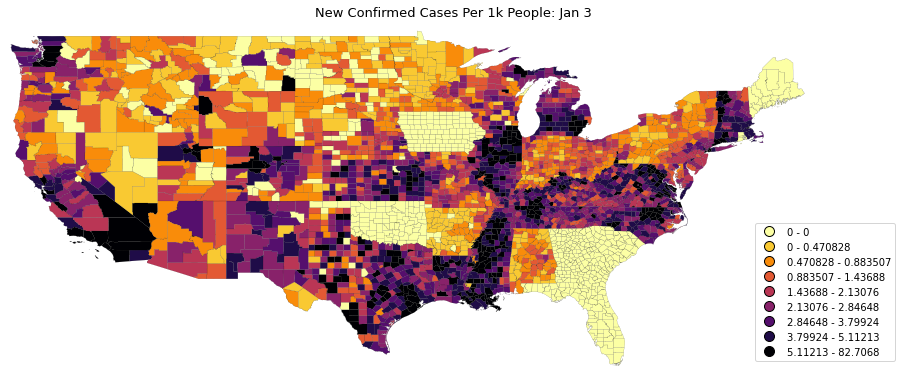

In [ ]:
# Initialize the figure
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(merged_jan3['cases_per_1k'], k=10)

import geoplot as gplt
# Map
gplt.choropleth(merged_jan3, 
    hue="cases_per_1k", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);

xlim = (-125, -60.)
ylim = (25., 50.)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('New Confirmed Cases Per 1k People: Jan 3', fontsize=13);

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 9
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/usr/local/lib/python3.7/dist-packages/geoplot/geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


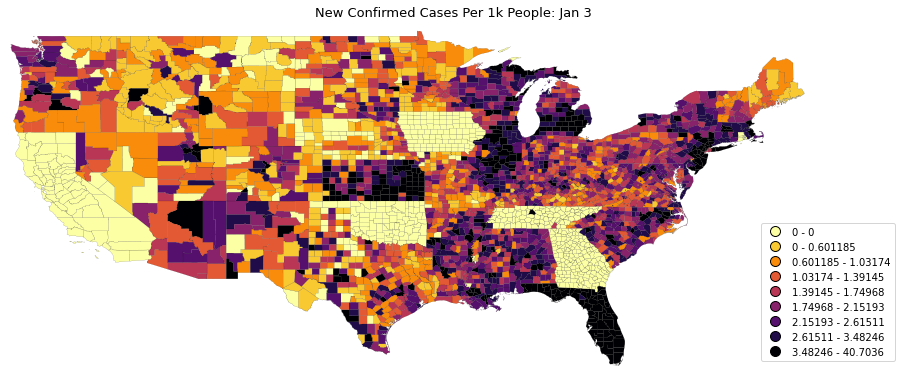

In [ ]:
# Initialize the figure
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(merged_jan7['cases_per_1k'], k=10)

import geoplot as gplt
# Map
gplt.choropleth(merged_jan7, 
    hue="cases_per_1k", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
);

xlim = (-125, -60.)
ylim = (25., 50.)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('New Confirmed Cases Per 1k People: Jan 3', fontsize=13);